### pakages

In [233]:
from IPython.display import display,HTML
display(HTML("<style>.container {width:95% !important;}</style>"))
import pandas as pd
pd.set_option('display.max_columns',200)

import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats


#modeling

from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm


#
import warnings 
warnings.filterwarnings('ignore')

# ADP 24회 실기 문제

```{admonition} 1번
**데이터 확인 및 전처리**     
- 데이터 설명
    - 성별(sex) 바이너리 : 'F' - 여성 또는 'M' - 남성     
    - 나이(age) 숫자: 15 - 22     
    - 부모님동거여부 (Pstatus) 바이너리: T: 동거 또는 'A': 별거       
    - 엄마학력(Medu) 숫자 : 0 : 없음, 1 : 초등 교육, 2 : 5-9학년, 3 - 중등 교육 또는 4 - 고등 교육    
    - 아빠학력(Fedu) 숫자 : 0 : 없음, 1 : 초등 교육, 2 : 5-9학년, 3 - 중등 교육 또는 4 - 고등 교육   
    - 주보호자(guardian) 명목형 : '어머니', '아버지' 또는 '기타'     
    - 등하교시간(traveltime) 숫자 : 1 : 15분이하, 2 : 15 ~ 30분, 3 : 30분 ~ 1시간, 4 : 1시간 이상       
    - 학습시간(studytime) 숫자 : 1 : 2시간이하, 2 : 2~5시간, 3 : 5~10시간, 4 : 10시간이상    
    - 학고횟수(failures)  숫자 : 1, 2, 3 else 4     
    - 자유시간(freetime) 숫자 : 1(매우 낮음), 2, 3, 4, 5(매우 높음)   
    - 가족관계(famrel) 숫자 : 1(매우 나쁨), 2, 3, 4, 5(우수)    
```

## 1.1 데이터 EDA 및 시각화 

,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
결측치숫자,0,3,0,0,0,0,0,3,0,0,5,0
유니크 값 숫자,2,8,2,5,5,3,4,4,4,5,5,34
types,object,float64,object,int64,int64,object,int64,float64,int64,int64,float64,int64
unique sample 3,"['F', 'M']","[18.0, 17.0, 15.0]","['A', 'T']","[4, 1, 2]","[4, 1, 3]","['mother', 'father', 'other']","[2, 3, 1]","[2.0, 1.0, 3.0]","[0, 3, 2]","[4, 5, 3]","[3.0, 2.0, 4.0]","[6, 4, 10]"


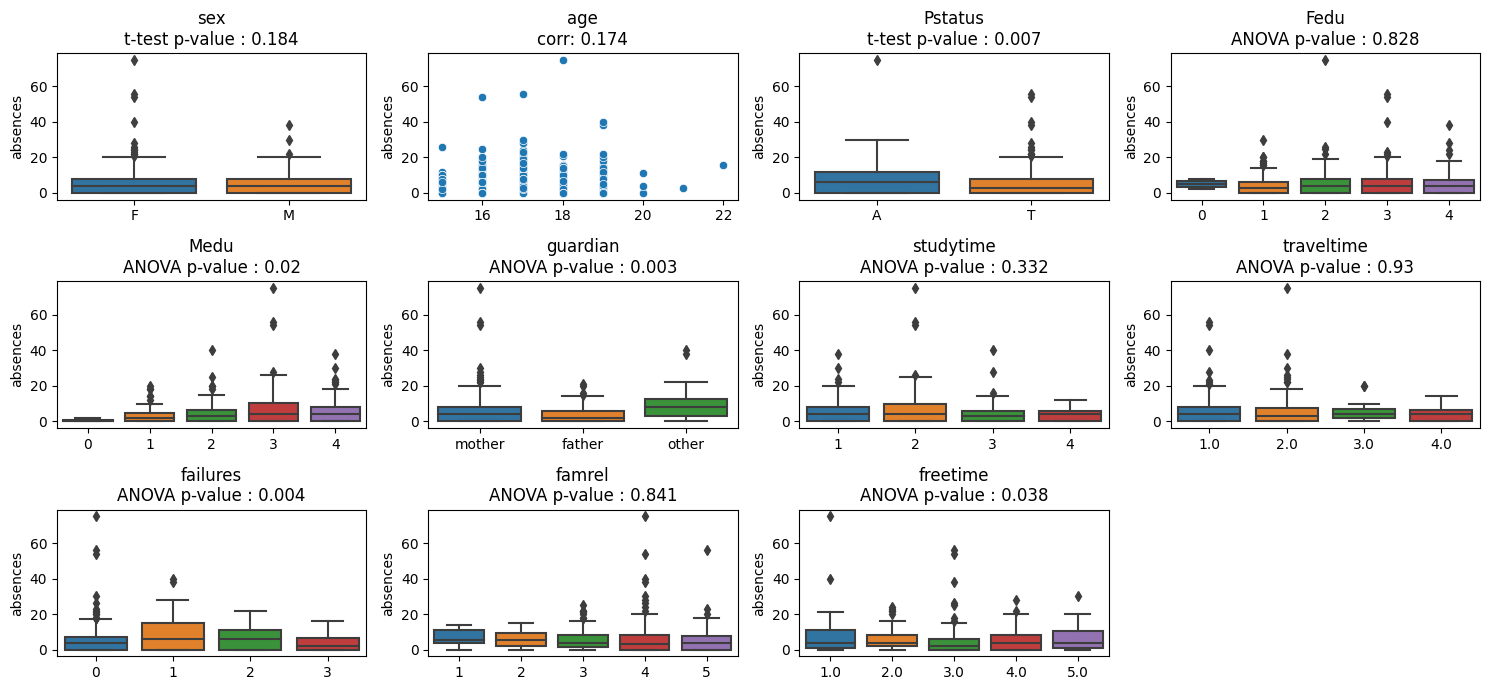

답안
age를 제외한 컬럼들은 모두 범주형 변수이다. sex화 Pstatus의 경우 uniuqe값이 2개이고 그외 범주형 변수들은 그 이상이다.
연속형 변수인 age와 absences간의 상관계수는 0.174로 낮은 상관성을 보인다.
sex와 Pstatus는 독립표본 t검정을 시행했을때 sex는 p-value가 0.184로 유의수준 0.05하에서 남녀 차이가 없으며
Pstatus의 경우 p-value는 0.007로 귀무가설을 기각한다. 즉 A,T사이에 유의한 차이가 존재한다.
두개 컬럼을 제외한 범주형 변수는 일원분산분석으로 차이가 존재하는 그룹이 있는지만 확인 한다. p-value가 0.05이하인 컬럼은
Medu,guardian,faiures,freetime이다. 그외 범주형 변수는 범주간 차이가 없다고 볼 수 있다.
결측치는 age와 traveltime,freetime 3개컬럼에서 존재한다.


In [177]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/24/problem1.csv')
df.head()

nulls = df.isnull().sum().to_frame().T
nulls.index = ['결측치숫자']
uniques = df.nunique().to_frame().T
uniques.index = ['유니크 값 숫자']
types =df.dtypes.to_frame().rename(columns ={0:'types'}).T
un = pd.DataFrame([str(list(df[x].unique()[:3])) for x in df.columns],index=df.columns,columns =['unique sample 3']).T

t = pd.concat([nulls,uniques,types,un])
display(t)



fig,axes = plt.subplots(3,4 , figsize=(15,7))
for i,ax in enumerate(axes.flat[:-1]): # absences 제거한 11개 plot
    
    n_col_name = df.columns[i]
    target = df[[n_col_name, 'absences']]
    
    if n_col_name =='age': # numeric columns to scatter
        sns.scatterplot(data=target,x = n_col_name, y ='absences',ax=ax)
        corr = round(target.corr().iloc[0,1],3)
        
        ax.set_title(n_col_name+ f'\ncorr: {corr}')
    else:
        sns.boxplot(data=target,x = n_col_name, y ='absences',ax=ax)
        n_unique = target[n_col_name].nunique()

        if n_unique ==2: 
            # t-test
            t_statistic, p_value = stats.ttest_ind(target.query(\
                            f"{n_col_name} =='{target[n_col_name].unique()[0]}'")['absences'], \
                        target.query(\
                            f"{n_col_name} =='{target[n_col_name].unique()[1]}'")['absences'])           


            round_p =round(p_value,3)
            ax.set_title(n_col_name + f"\nt-test p-value : {round_p}")

        else:
            # anova                               
            
            f_statistic, p_value = stats.f_oneway(*[list(x)[0] for x in target.groupby([n_col_name]).agg(list).values])
            round_p =round(p_value,3)
            ax.set_title(n_col_name + f"\nANOVA p-value : {round_p}")
            
            
    ax.set_xlabel('')
    
    
axes.flat[-1].remove()
fig.tight_layout()
plt.show()
print('답안\nage를 제외한 컬럼들은 모두 범주형 변수이다. sex화 Pstatus의 경우 uniuqe값이 2개이고 그외 범주형 변수들은 그 이상이다.')
print('연속형 변수인 age와 absences간의 상관계수는 0.174로 낮은 상관성을 보인다.')
print('sex와 Pstatus는 독립표본 t검정을 시행했을때 sex는 p-value가 0.184로 유의수준 0.05하에서 남녀 차이가 없으며')
print('Pstatus의 경우 p-value는 0.007로 귀무가설을 기각한다. 즉 A,T사이에 유의한 차이가 존재한다.')
print('두개 컬럼을 제외한 범주형 변수는 일원분산분석으로 차이가 존재하는 그룹이 있는지만 확인 한다. p-value가 0.05이하인 컬럼은')
print('Medu,guardian,faiures,freetime이다. 그외 범주형 변수는 범주간 차이가 없다고 볼 수 있다.')
print('결측치는 age와 traveltime,freetime 3개컬럼에서 존재한다.')

## 1.2 결측치 처리 및 변화 시각화, 추가 전처리가 필요하다면 이유와 기대효과를 설명하라

In [178]:
df['age'].fillna(df['age'].mean(),inplace=True)
df['traveltime'].fillna(df['traveltime'].mode()[0],inplace=True)
df['freetime'].fillna(df['freetime'].mode()[0],inplace=True)



after_nulls = df.isnull().sum().to_frame().T
after_nulls.index = ['결측치 제거 후 결측치 숫자']

t = pd.concat([nulls,after_nulls])

print('답안\n결측치는 연속형 변수의 경우 평균, 범주형 변수의 경우 최빈값으로 대치한다.')
print('숫자형이지 않은 범주형 변수(sex,Pstatus)의 경우 원핫인코딩을 진행한다. 모델학습에 적합한 형태로 전처리한다')

display(t)
df_dummies = pd.get_dummies(df)
display(df_dummies.head())

답안
결측치는 연속형 변수의 경우 평균, 범주형 변수의 경우 최빈값으로 대치한다.
숫자형이지 않은 범주형 변수(sex,Pstatus)의 경우 원핫인코딩을 진행한다. 모델학습에 적합한 형태로 전처리한다


,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
결측치숫자,0,3,0,0,0,0,0,3,0,0,5,0
결측치 제거 후 결측치 숫자,0,0,0,0,0,0,0,0,0,0,0,0


,age,Fedu,Medu,studytime,traveltime,failures,famrel,freetime,absences,sex_F,sex_M,Pstatus_A,Pstatus_T,guardian_father,guardian_mother,guardian_other
0,18.00000,4,4,2,2.0,0,4,3.0,6,1,0,1,0,0,1,0
1,17.00000,1,1,2,1.0,0,5,3.0,4,1,0,0,1,1,0,0
2,15.00000,1,1,2,1.0,3,4,3.0,10,1,0,0,1,0,1,0
3,15.00000,2,4,3,1.0,0,3,2.0,2,1,0,0,1,0,1,0
4,16.69898,3,3,2,1.0,0,4,3.0,4,1,0,0,1,1,0,0


## 1.3 결석일수 예측모델을 2개 제시하고 선택한 근거 설명

In [241]:
print('결석 일수의 경우 회귀 모델을 선택해야한다. 두가지 모델은 랜덤포레스트와 선형 회귀 모델을 선택한다.')
print('선형회귀모델의 경우 회귀모델의 가장 기본적인 모델이기 때문에 선택했고')
print('랜덤 포레스트 모델의 경우 스케일링이나 범주형 변수 인코딩 유무에 상관없이 강건한 성격을 보이기에 선택했다.')

결석 일수의 경우 회귀 모델을 선택해야한다. 두가지 모델은 랜덤포레스트와 선형 회귀 모델을 선택한다.
선형회귀모델의 경우 회귀모델의 가장 기본적인 모델이기 때문에 선택했고
랜덤 포레스트 모델의 경우 스케일링이나 범주형 변수 인코딩 유무에 상관없이 강건한 성격을 보이기에 선택했다.


## 1.4 선정한 모델 2가지 생성 및 모델의 평가 기준을 선정하고 선정 이유 설명

In [240]:
x = df_dummies.drop(columns =['absences'])
y = df_dummies['absences']


x_train,x_test,y_train,y_test = train_test_split(x,y,random_state =1,test_size=0.3)


rf = RandomForestRegressor(random_state=2)
lr = LinearRegression()

rf.fit(x_train,y_train)
lr.fit(x_train,y_train)

pred_rf = rf.predict(x_test)
pred_lr = lr.predict(x_test)

mse_rf = mean_squared_error(y_test,pred_rf)
mse_lr = mean_squared_error(y_test,pred_lr)


result =pd.DataFrame([mse_rf,mse_lr],columns =['r2_score'])
result.index = ['랜덤포레스트 mse','선형회귀 mse']

print('답안\ntrain,test분리를 7:3으로 하고 평균제곱오차(mse)값을 기준으로 모델을 평가한다.')
print('해당 지표를 선정한 이유는 예측 오차의 제곱으로 계산하기에 오차에 민감하다는 장점이 있다')
print('모델의 결과는 아래와 같다. mse값은 그 값이 작을 수록 좋은 모델이다.')
print('선형회귀 모델이 랜덤포레스트 모델보다 좋은 결과를 보였다.')
display(result)

답안
train,test분리를 7:3으로 하고 평균제곱오차(mse)값을 기준으로 모델을 평가한다.
해당 지표를 선정한 이유는 예측 오차의 제곱으로 계산하기에 오차에 민감하다는 장점이 있다
모델의 결과는 아래와 같다. mse값은 그 값이 작을 수록 좋은 모델이다.
선형회귀 모델이 랜덤포레스트 모델보다 좋은 결과를 보였다.


,r2_score
랜덤포레스트 mse,75.732523
선형회귀 mse,36.725670


## 1.5 모델이 다양한 일상 상황에서도 잘 동작한다는 것을 설명하고 시각화 하라

In [256]:
print('답안\n스터디원 예시1')
print('현재 모델성능 좋지 않음 -> 차원 축소 -> 결석일수가 random으로 퍼져있음 확인 -> 다른 독립변수 찾아서 개선시키겠다')
print('\n스터디원 예시2')
print('교차 검증을 통해 일반화 능력을 평가하고 과적합 방지 / 다양한 상황에서 잘 동작하는것 확인')
print('\n스터디원 예시3')
print('잔차가 rnadom하게 흩어져 있는것을 확인 -> 최적의 모델이 아님 -> 잘 동작 하게 하기 위한 방안 제안')
print('\n스터디원 예시4')
print('다른 추가 트리계열 모델로 학습 -> 모델 성능이 좋지 않음을 확인 -> 일상 상황 잘 동작하지 않는다 결론')


답안
스터디원 예시1
현재 모델성능 좋지 않음 -> 차원 축소 -> 결석일수가 random으로 퍼져있음 확인 -> 다른 독립변수 찾아서 개선시키겠다

스터디원 예시2
교차 검증을 통해 일반화 능력을 평가하고 과적합 방지 / 다양한 상황에서 잘 동작하는것 확인

스터디원 예시3
잔차가 rnadom하게 흩어져 있는것을 확인 -> 최적의 모델이 아님 -> 잘 동작 하게 하기 위한 방안 제안

스터디원 예시4
다른 추가 트리계열 모델로 학습 -> 모델 성능이 좋지 않음을 확인 -> 일상 상황 잘 동작하지 않는다 결론


## 1.6 모델 최적화 방안에 대해 구체적으로 설명하라

In [245]:
print('선형모델의 최적화를 위해서 스케일링과 연속성을 보이지 않는 범주형 변수들에 대한 추가적인 더미화를 진행시킨 후 모델링을 해볼 수 있다.')
print('또한 선형 모델의 경우 변수 선택법과 위에서 확인 했던 통계적 검정결과를 종합하여 예측에 최적화된 변수를 선택하는 실험을 해볼 수 있다.')

선형모델의 최적화를 위해서 스케일링과 연속성을 보이지 않는 범주형 변수들에 대한 추가적인 더미화를 진행시킨 후 모델링을 해볼 수 있다.
또한 선형 모델의 경우 변수 선택법과 위에서 확인 했던 통계적 검정결과를 종합하여 예측에 최적화된 변수를 선택하는 실험을 해볼 수 있다.


```{admonition} 2번
**광고횟수와 광고비에 따른 매출액의 데이터이다**     
```

In [122]:
import pandas as pd

df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/24/problem2.csv',encoding='cp949')
df.head()


,광고횟수,광고비,매출액
0,2,낮음,15
1,3,낮음,16
2,4,낮음,17
3,4,높음,18
4,5,높음,20


## 2.1 광고비 변수를 가변수 처리후 다중회귀를 수행하여 회귀계수가 유의한지 검정

In [160]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/24/problem2.csv',encoding='cp949')
df['광고비']  =df['광고비'].map({'낮음':0,'높음':1})

y= df['매출액']
x = df[['광고횟수','광고비']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
display(model.summary().tables[1])
print('답안\n광고비 변수의 unique값은 낮음과 높음이다. 이를 각각 0과 1로 가변수 처리하고 다중회귀를 수행한 결과이다.')
print('상수항과 광고횟수에 대해서는 p-value가 0 광고비는 0.358이다.')
print('해당 검정의 귀무가설은 "해당 독립 변수의 회귀계수는 0이다. 즉, 해당 독립 변수는 종속 변수에 영향을 미치지 않는다" 이고')
print('대립가설은 "해당 독립 변수의 회귀계수는 0이 아니다. 즉, 해당 독립 변수는 종속 변수에 영향을 미친다." 이다')
print('유의 수준 0.05하에서 광고비는 유의하지 않은 회귀계수이다')

,coef,std err,t,P>|t|,[0.025,0.975]
const,12.1641,0.556,21.876,0.000,10.882,13.446
광고횟수,1.4350,0.074,19.518,0.000,1.265,1.605
광고비,0.5227,0.536,0.975,0.358,-0.713,1.759


답안
광고비 변수의 unique값은 낮음과 높음이다. 이를 각각 0과 1로 가변수 처리하고 다중회귀를 수행한 결과이다.
상수항과 광고횟수에 대해서는 p-value가 0 광고비는 0.358이다.
해당 검정의 귀무가설은 "해당 독립 변수의 회귀계수는 0이다. 즉, 해당 독립 변수는 종속 변수에 영향을 미치지 않는다" 이고
대립가설은 "해당 독립 변수의 회귀계수는 0이 아니다. 즉, 해당 독립 변수는 종속 변수에 영향을 미친다." 이다
유의 수준 0.05하에서 광고비는 유의하지 않은 회귀계수이다


## 2.2 회귀식이 유의한지 판단

In [140]:
display(model.summary().tables[0])
print('답안\n회귀분석에서 F-통계량은 다음과 같은 귀무가설과 대립가설에 대한 검정에 사용된다.')
print('귀무가설 : "모든 독립 변수의 회귀계수가 0이다. 즉, 모든 독립 변수들은 종속 변수에 영향을 미치지 않는다." 이고')
print('대립가설 : "적어도 하나의 독립 변수의 회귀계수는 0이 아니다. 즉, 적어도 하나의 독립 변수는 종속 변수에 영향을 미친다." 이다')
print('회귀식에 대한 통계값들은 위 테이블에서 보는것과 같다. F통계량에 대한 p-value값은 9.96e-08이다.')
print('그러므로 귀무가설을 기각한다. 즉 적어도 하나의 독립 변수의 회귀계수는 0이 아니며 유의한 회귀식이다.')
print('또한 결정계수 (R-squared)값은 0.982로 최대값인 1에 가깝기에 유의하다 볼 수 있다.')
print('그러나 전체 데이터 숫자가 11개로 작은 편이므로 추가되는 데이터에 대해 강건하게 반응하지는 않을 수 있다.')

Dep. Variable:,매출액,R-squared:,0.982
Model:,OLS,Adj. R-squared:,0.978
Method:,Least Squares,F-statistic:,221.2
Date:,"Fri, 18 Aug 2023",Prob (F-statistic):,9.96e-08
Time:,23:20:47,Log-Likelihood:,-11.883
No. Observations:,11,AIC:,29.77
Df Residuals:,8,BIC:,30.96
Df Model:,2,,
Covariance Type:,nonrobust,,


답안
회귀분석에서 F-통계량은 다음과 같은 귀무가설과 대립가설에 대한 검정에 사용된다.
귀무가설 : "모든 독립 변수의 회귀계수가 0이다. 즉, 모든 독립 변수들은 종속 변수에 영향을 미치지 않는다." 이고
대립가설 : "적어도 하나의 독립 변수의 회귀계수는 0이 아니다. 즉, 적어도 하나의 독립 변수는 종속 변수에 영향을 미친다." 이다
회귀식에 대한 통계값들은 위 테이블에서 보는것과 같다. F통계량에 대한 p-value값은 9.96e-08이다.
그러므로 귀무가설을 기각한다. 즉 적어도 하나의 독립 변수의 회귀계수는 0이 아니며 유의한 회귀식이다.
또한 결정계수 (R-squared)값은 0.982로 최대값인 1에 가깝기에 유의하다 볼 수 있다.
그러나 전체 데이터 숫자가 11개로 작은 편이므로 추가되는 데이터에 대해 강건하게 반응하지는 않을 수 있다.


```{admonition} 3번
**A생산라인의 12개 제품 평균은 5.7mm이고 표준편차는 0.03, B생산라인의 12개 제품 평균은 5.6mm이고 표준편차는 0.04이다.  5%유의수준으로 두 제품의 평균이 차이가 있는지 여부를 검정하라 Z(0.05) = 1.96**

```

## 3.1 귀무가설과 대립가설을 세워라

In [156]:
print('답안\n위 문제는 두개의 생산라인의 평균에 대한 차이가 있는지 t-검정을 수행한다.')
print('귀무가설 :A생산라인의 제품 평균과 B생산라인의 제품 평균은 차이가 없다.')
print('대립가설 :A생산라인의 제품 평균과 B생산라인의 제품 평균은 차이가 있다.')

답안
위 문제는 두개의 생산라인의 평균에 대한 차이가 있는지 t-검정을 수행한다.
귀무가설 :A생산라인의 제품 평균과 B생산라인의 제품 평균은 차이가 없다.
대립가설 :A생산라인의 제품 평균과 B생산라인의 제품 평균은 차이가 있다.


## 3.2 두 평균이 차이가 있는지 검정하라

In [249]:
# chatgpt 냥냥하게..
mean_A = 5.7
stddev_A = 0.03
mean_B = 5.6
stddev_B = 0.04
alpha = 0.05
n = 12
std_error_diff = np.sqrt((stddev_A**2 / n) + (stddev_B**2 / n))
t = (mean_A - mean_B) / std_error_diff
df = 2*n - 2
p_value = 2 * (1 - stats.t.cdf(abs(t), df))
p_value

5.892973662380285e-07

## 4 바이러스 감염 분류표를 보고 베이지안 분류 방법을 사용해 양성으로 예측된 사람이 실제로 양성일 확률을 구하라
- 인구중 양성 비율(사전 확률)이 주어지지 않았었네요 죄송합니다. 0.01로 두고 풀겠습니다.

![image](https://github.com/Datamanim/datarepo/blob/main/adp/24/problem4.png?raw=true)

In [174]:
tp = 370
fn = 15
fp = 10
tn = 690
disease_rate = 0.01
result = (tp/(tp +fn))*disease_rate/\
        ((tp/(tp +fn))*disease_rate+((fp/(tn+fp))*(1-disease_rate)))
print(result)

0.4045926735921268


```{admonition} 5번
**주어진 데이터에서 신뢰구간을 구하려한다**     
정규분포에서 표폰을 추출함[Z(0.05) = -1.65 , Z(0.025) = -1.96, T(0.05, 8) = 1.860 , T0.025(0.025, 8) = 2.306]       
데이터(9개) : [3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3 4.4, 4.7]     
```

## 5.1 모분산을 모르는 경우 주어진 데이터의 95% 신뢰구간을 구하라

In [247]:
# chatgpt 냥냥하게..
data = [3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.4, 4.7]
n = len(data)
mean = np.mean(data)
stddev = np.std(data, ddof=1) 
SE = stddev / np.sqrt(n)

alpha = 0.05
degrees_of_freedom = n - 1
t_critical = stats.t.ppf(1 - alpha/2, degrees_of_freedom)

margin_of_error = t_critical * SE

confidence_interval = (mean - margin_of_error, mean + margin_of_error)
confidence_interval

(3.4777333086019713, 4.300044469175806)

## 5.2 sigma = 0.04인걸 알고 있을때의 95% 신뢰구간을 구하라

In [248]:
# chatgpt 냥냥하게..
n = len(data)
mean = np.mean(data)
sigma = 0.04

alpha = 0.05
Z_critical = stats.norm.ppf(1 - alpha/2)  

margin_of_error = Z_critical * (sigma / np.sqrt(n))

confidence_interval = (mean - margin_of_error, mean + margin_of_error)
confidence_interval

(3.862756035761688, 3.9150217420160898)